In [1]:
# Imports
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf
#import tensorflow_hub as hub
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer,  make_column_selector as selector

#from sklearn.metrics import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import unicodedata
import random
from sklearn.model_selection import GridSearchCV

from transformers import BertTokenizer, BertModel
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from nltk.tokenize import TweetTokenizer
from sklearn.neural_network import MLPClassifier

In [2]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [59]:
df = pd.read_csv("../data/brand_product_emotion.csv", encoding= 'unicode_escape')

In [60]:
sw = stopwords.words('english')

In [61]:
def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def preprocess_tweet_1(doc, stop_words=sw):
    '''
    Preprocesses a tweet by lemmatizing words, removing stopwords, making lowercase,
    stripping punctuation and numbers, removing mentions and the hashtag "#sxsw",
    and removing strings in the form of "{link}".
    
    :param doc: a document (tweet)
    :return: preprocessed document string
    '''

    # Tokenize the document
    regex_token = TweetTokenizer()
    doc = regex_token.tokenize(doc)
    
    # Convert to lowercase
    doc = [word.lower() for word in doc]
    
    #remove all punct
    doc = [word for word in doc if word not in string.punctuation]
    
    # Remove stopwords
    doc = [word for word in doc if word not in sw]
    
    # Remove mentions and hashtag
    doc = [word for word in doc if not word.startswith('@') and word != '#sxsw' and word != 'rt']
    
    # Remove strings in the form of "{link}"
    doc = [word for word in doc if not re.match(r'^\{link\}$', word)]
    
    # Perform POS tagging
    doc = pos_tag(doc)
    
    # Lemmatize words based on their POS tags
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    # Join the preprocessed words back into a string
    return ' '.join(doc)

In [62]:
def preprocess_tweet_2(tweet):
    # Remove URL and mentions (keep hashtags but remove sxsw/rt at the end)
    text = ' '.join(word for word in tweet.split() if not (word.startswith('http') or word.startswith('@') or word.startswith('{')))
    
    # Remove specific symbols
    text = re.sub(r'[@#{}]', '', text)
    
    # Remove punctuation and convert to lowercase
    text = ''.join(char for char in text if char.isalnum() or char.isspace())
    text = text.lower()
    
    # Tokenize text and remove stop words
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in sw]
    
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Remove specific words
    tokens = [word for word in tokens if word not in ['rt', 'sxsw']]
    
    # Join back
    preprocessed_tweet = ' '.join(tokens)
    
    return preprocessed_tweet

In [63]:
new_col_names = {'tweet_text': 'tweet', 
                 'emotion_in_tweet_is_directed_at':'brand_product', 
                 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}
df = df.rename(columns=new_col_names)

df.dropna(subset = ['tweet'], inplace = True)

df['emotion'] = df['emotion'].replace("Positive emotion","positive")
df['emotion'] = df['emotion'].replace("Negative emotion","negative")
df['emotion'] = df['emotion'].replace("No emotion toward brand or product","neutral")
df['emotion'] = df['emotion'].replace("I can't tell","unknown")

emotion_map = {'neutral': 0, 'positive': 1, 'negative': 2, 'unknown':3}
df['target'] = df['emotion'].map(emotion_map)

df.drop('emotion', axis = 1, inplace = True)

df

,tweet,brand_product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,1
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,1
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,0
9090,"Google's Zeiger, a physician never reported po...",NaN,0
9091,Some Verizon iPhone customers complained their...,NaN,0


### Binary Classifier MNB

In [64]:
df_binary = df[(df['target']!= 0) & (df['target']!= 3)]

In [65]:
df_binary['target'].value_counts()

1    2978
2     570
Name: target, dtype: int64

In [66]:
X = df_binary['tweet'].apply(preprocess_tweet_1)
y = df_binary['target']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [67]:
X[9079]

'papyrus ... sort like ipad nice lol lavelle'

In [68]:
X_train

2802    great blog late news ... like open #apple stor...
440     lovin digital band sings iphone play guitar ap...
1314    we're give away ipad 2 creator popular disc in...
6226                                  ipad 2 thanks #fxsw
5273    #geogames #android develop geo-games tweet u w...
                              ...                        
2760    dear apple could roll hot dog cart full ipad 2...
3151    kick #sxswi give away ipad 2 ... visit fb page...
2121                 #cnngrill rockin #iphone cooler link
8989            crazy much culture document google doodle
8094    woot #google #lego hackathon competition #star...
Name: tweet, Length: 2838, dtype: object

In [69]:
mnb_tfidf_pipeline = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("mnb", MultinomialNB())
])

mnb_cv_pipeline = Pipeline([
    ("cv", CountVectorizer()),
    ("mnb", MultinomialNB())
])


In [70]:
mnb_tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('mnb', MultinomialNB())])

In [71]:
mnb_cv_pipeline.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer()), ('mnb', MultinomialNB())])

CV Results for `mnb_binary_tfidf` model:
            0.84884 ± 0.00455 accuracy
        


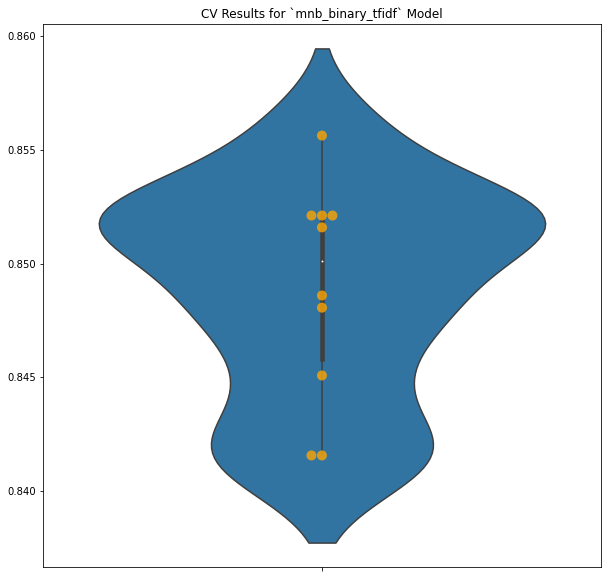

In [72]:
mnb_tfidf_model = ModelWithCV(
    mnb_tfidf_pipeline,
model_name = 'mnb_binary_tfidf',
X = X_train,
y = y_train)

fig, ax = plt.subplots(figsize = (10,10))
mnb_tfidf_model.plot_cv(ax=ax)
mnb_tfidf_model.print_cv_summary()

CV Results for `mnb_binary_cv` model:
            0.86963 ± 0.01526 accuracy
        


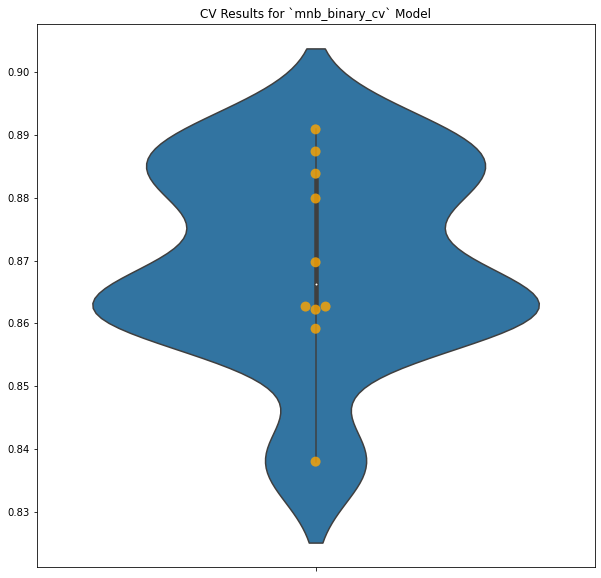

In [73]:
mnb_cv_model = ModelWithCV(
    mnb_cv_pipeline,
model_name = 'mnb_binary_cv',
X = X_train,
y = y_train)

fig, ax = plt.subplots(figsize = (10,10))
mnb_cv_model.plot_cv(ax=ax)
mnb_cv_model.print_cv_summary()

              precision    recall  f1-score   support

           1       0.84      1.00      0.92       595
           2       1.00      0.04      0.08       115

    accuracy                           0.85       710
   macro avg       0.92      0.52      0.50       710
weighted avg       0.87      0.85      0.78       710



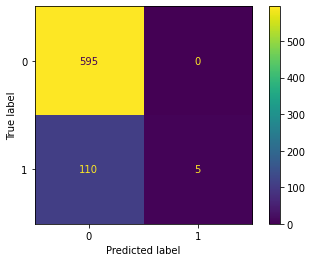

In [74]:
y_pred = mnb_tfidf_pipeline.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

              precision    recall  f1-score   support

           1       0.88      0.96      0.92       595
           2       0.63      0.32      0.43       115

    accuracy                           0.86       710
   macro avg       0.75      0.64      0.67       710
weighted avg       0.84      0.86      0.84       710



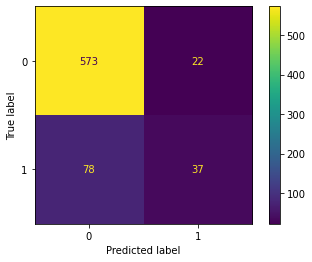

In [75]:
y_pred = mnb_cv_pipeline.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Idk why i keep giving tfidf a chance. It has proven to be the worst for this model. I will not be using tfidf from this moment forward

## Grid searching on cv only

In [85]:
X_test

685     new post : ipad 2 launch huge line apple pop-u...
6393    nyt app ipad : " here's amaze way serve reader...
7851    steve job position iphone device make china su...
5813    google circle toast can't convince facebook us...
2944    thanks give new top cover bang juicepack iphon...
                              ...                        
2707    hire qualify talented woman consciously early ...
2770    oh , #apple ... ridiculous : even begin , appl...
6653    set pop shop smart move ipad imho | developer ...
2127    : " apple come cool technology one's ever hear...
5565    best thing i've hear weekend " give ipad 2 mon...
Name: tweet, Length: 710, dtype: object

In [76]:
parameters = {
    'cv__max_features': [10000,20000,15000],  # Number of features to consider
    'cv__max_df': [.9,.8,.85],
    'cv__min_df': [2, 5, 10],
    'cv__ngram_range': [(1, 1), (1, 2)],  # Range of n-grams to generate
    'mnb__alpha': [0.1, 1.0, 10.0]  # Smoothing parameter for MultinomialNB
}
# Define the grid search
grid_search = GridSearchCV(mnb_cv_pipeline, parameters, cv=5, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

bestpipe = grid_search.best_estimator_

Best Parameters:  {'cv__max_df': 0.9, 'cv__max_features': 10000, 'cv__min_df': 2, 'cv__ngram_range': (1, 2), 'mnb__alpha': 1.0}
Best Score:  0.8629393645825569


              precision    recall  f1-score   support

           1       0.88      0.95      0.91       595
           2       0.57      0.36      0.44       115

    accuracy                           0.85       710
   macro avg       0.73      0.65      0.68       710
weighted avg       0.83      0.85      0.84       710



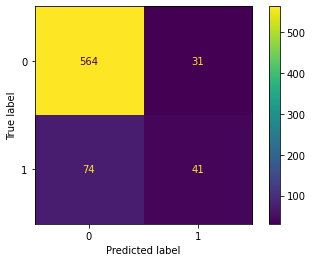

In [77]:
#predict sentiment on test set
y_pred = bestpipe.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

## Trying out MNB - CV again but with text_preprocessing 2

In [78]:
X = df_binary['tweet'].apply(preprocess_tweet_2)
y = df_binary['target']
X[9079]

'quotpapyrussort like ipadquot nice lol lavelle'

In [79]:
type(X)

pandas.core.series.Series

In [80]:
X = X.to_frame()  # Convert Series to DataFrame
X['tweet'] = X['tweet'].str.replace('quot', '')  # Replace 'quot' in 'tweet' column

In [81]:
X = X['tweet']

In [82]:
X[9079]

'papyrussort like ipad nice lol lavelle'

In [83]:


X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

CV Results for `mnb_binary_cv_preprocess_2` model:
            0.87351 ± 0.01724 accuracy
        


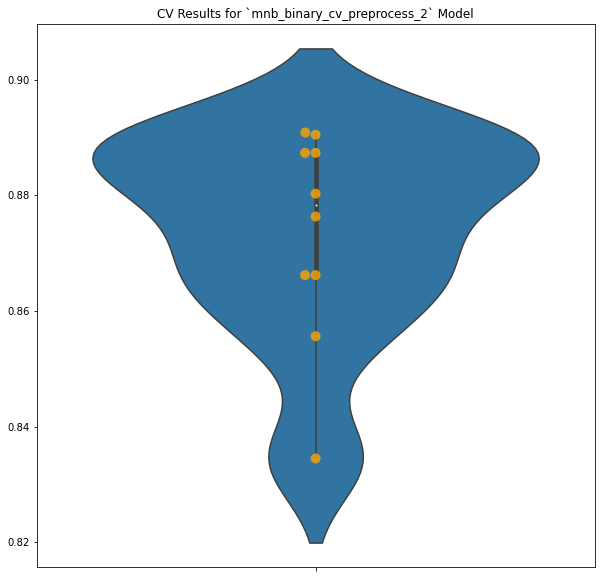

In [84]:
mnb_cv_pipeline = Pipeline([
    ("cv", CountVectorizer()),
    ("mnb", MultinomialNB())
])

mnb_cv_pipeline.fit(X_train, y_train)

mnb_cv_model = ModelWithCV(
    mnb_cv_pipeline,
model_name = 'mnb_binary_cv_preprocess_2',
X = X_train,
y = y_train)

fig, ax = plt.subplots(figsize = (10,10))
mnb_cv_model.plot_cv(ax=ax)
mnb_cv_model.print_cv_summary()

              precision    recall  f1-score   support

           1       0.88      0.97      0.92       595
           2       0.65      0.32      0.43       115

    accuracy                           0.86       710
   macro avg       0.76      0.64      0.68       710
weighted avg       0.84      0.86      0.84       710



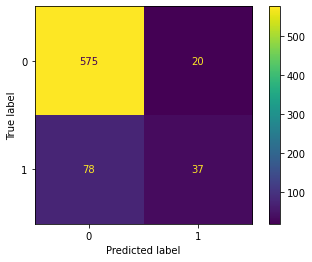

In [85]:
y_pred = mnb_cv_pipeline.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [53]:
# slight improvement over original base cv-mnb. Will gridsearch this now

In [86]:
parameters = {
    'cv__max_features': [20000,25000],  # Number of features to consider
    #'cv__max_df': [.9,.8,.85],
    #'cv__min_df': [2, 5, 10],
    'cv__ngram_range': [(1, 1), (1, 2)],  # Range of n-grams to generate
    'mnb__alpha': [0.1, 1.0, 10.0]  # Smoothing parameter for MultinomialNB
}
# Define the grid search
grid_search = GridSearchCV(mnb_cv_pipeline, parameters, cv=5, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

bestpipe = grid_search.best_estimator_

Best Parameters:  {'cv__max_features': 20000, 'cv__ngram_range': (1, 2), 'mnb__alpha': 1.0}
Best Score:  0.875968775616663


              precision    recall  f1-score   support

           1       0.88      0.98      0.93       595
           2       0.81      0.33      0.47       115

    accuracy                           0.88       710
   macro avg       0.85      0.66      0.70       710
weighted avg       0.87      0.88      0.86       710



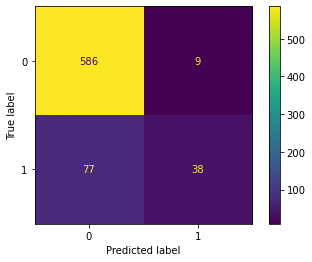

In [87]:
#predict sentiment on test set
y_pred = bestpipe.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

Did not improve as much as id like it to. Will make a text_preprocessing_3 for a differnt apprach to text preprocessing

In [88]:
def preprocess_tweet_3(doc, stop_words=sw):
    '''
    Preprocesses a tweet by lemmatizing words, removing stopwords, making lowercase,
    stripping punctuation and numbers, removing mentions and the hashtag "#sxsw",
    removing strings in the form of "{link}", and removing numbers.
    
    :param doc: a document (tweet)
    :return: preprocessed document string
    '''

    # Tokenize the document and remove punctuations and numbers
    regex_token = TweetTokenizer()
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc if word.isalpha()]  # Remove numbers
    doc = [word for word in doc if word not in string.punctuation]
    
    # Remove stopwords
    doc = [word for word in doc if word not in stop_words]
    
    # Remove mentions and hashtag
    doc = [word for word in doc if not word.startswith('@') and word != '#sxsw' and word != 'rt']
    
    # Remove strings in the form of "{link}"
    doc = [word for word in doc if not re.match(r'^\{link\}$', word)]
    
    # Perform POS tagging
    doc = pos_tag(doc)
    
    # Lemmatize words based on their POS tags
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    
    # Join the preprocessed words back into a string
    return ' '.join(doc)

### Modeling mnb-cv again with processor_3

In [89]:
X = df_binary['tweet'].apply(preprocess_tweet_3)
y = df_binary['target']
X[9079]

'papyrus sort like ipad nice lol lavelle'

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

CV Results for `mnb_binary_cv_preprocess_3` model:
            0.86858 ± 0.01624 accuracy
        


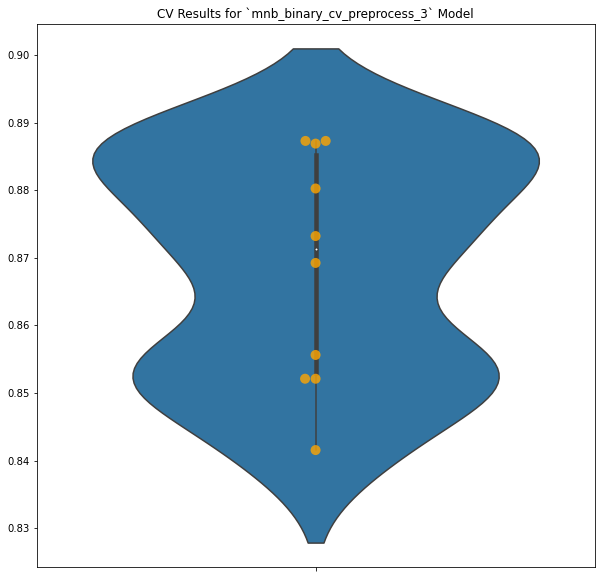

In [92]:
mnb_cv_pipeline = Pipeline([
    ("cv", CountVectorizer()),
    ("mnb", MultinomialNB())
])

mnb_cv_pipeline.fit(X_train, y_train)

mnb_cv_model = ModelWithCV(
    mnb_cv_pipeline,
model_name = 'mnb_binary_cv_preprocess_3',
X = X_train,
y = y_train)

fig, ax = plt.subplots(figsize = (10,10))
mnb_cv_model.plot_cv(ax=ax)
mnb_cv_model.print_cv_summary()

              precision    recall  f1-score   support

           1       0.88      0.97      0.92       595
           2       0.67      0.32      0.44       115

    accuracy                           0.86       710
   macro avg       0.78      0.65      0.68       710
weighted avg       0.85      0.86      0.84       710



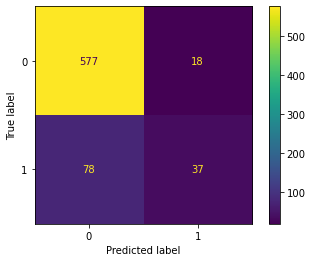

In [93]:
y_pred = mnb_cv_pipeline.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

In [104]:
#gridsearch again
parameters = {
    'cv__max_features': [15000,20000,17500],  # Number of features to consider
    #'cv__max_df': [.9,.8,.85],
    #'cv__min_df': [2, 5, 10],
    'cv__ngram_range': [(1, 1), (1, 2)],  # Range of n-grams to generate
    'mnb__alpha': [0.1, 1.0, 10.0]  # Smoothing parameter for MultinomialNB
}
# Define the grid search
grid_search = GridSearchCV(mnb_cv_pipeline, parameters, cv=5, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

bestpipe = grid_search.best_estimator_

Best Parameters:  {'cv__max_features': 15000, 'cv__ngram_range': (1, 2), 'mnb__alpha': 0.1}
Best Score:  0.8731500111781803


              precision    recall  f1-score   support

           1       0.90      0.94      0.92       595
           2       0.60      0.46      0.52       115

    accuracy                           0.86       710
   macro avg       0.75      0.70      0.72       710
weighted avg       0.85      0.86      0.86       710



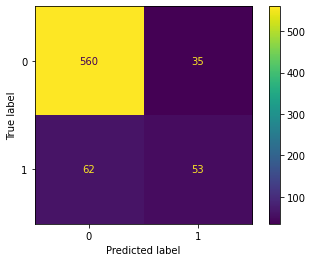

In [105]:
y_pred = bestpipe.predict(X_test)
#eval model
report = classification_report(y_test, y_pred)
print(report)
#make a conf matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm)
disp.plot()

### Conclusion:
- I think this is the best the model will get in the time being. Not very happy with .46 recall score but I believe with more data this could be ironed out
- Also have just realized, I ran out of time to attempt with SMOTE... Will try SMOTE on my own time.